# Implementation details

This section describes how `%%testcell` has been implemented under the hood.

**NOTE**: we use `default_exp __init__` in order to enable this as soon as you import the module.

**WARNING**: cells magic are striped out during documentation generation; this is the reason why there is the same cell magic as comment too.

In [ ]:
#| default_exp __init__

In [ ]:
#| export
import ast
from IPython.core.magic import register_cell_magic, needs_local_scope
from IPython import get_ipython # needed for quarto
from collections import namedtuple

WARNING: the official `IPython.display.Code` syntax hilighter don't seems to work. We're creating a "drop-in" replacement that force `full=True` in HtmlFormatter. This seems to work properly and give us more control on code display.
For details see: https://github.com/ipython/ipython/blob/72bb67ee8f57cb347ba358cce786c3fa87c470b9/IPython/lib/display.py#L667

In [ ]:
#| export
from pygments.formatters import HtmlFormatter
from pygments import highlight
from pygments.lexers import PythonLexer
from IPython.display import HTML

def Code(data=None, url=None, filename=None, language=None):
    return HTML(highlight(data, PythonLexer(), HtmlFormatter(full=True)))

In [ ]:
#| export
from testcell.core import auto_return
from testcell.inout import separate_args_and_inout, process_inout, split_and_strip, validate_and_update_inputs

## Valid arguments

In [ ]:
from fastcore.test import *

In [ ]:
#| export 
testcell_valid_args = {'verbose','dryrun','noglobals','noreturn','debug'} # set!

In [ ]:
#| export 
def parse_args(x):
    t = set([c for c in split_and_strip(x,' ') if c != ''])
    diff = t.difference(testcell_valid_args)
    if len(diff)>0: raise ValueError(f'Invalid arguments passed: "{",".join(diff)}"')
    return t

In [ ]:
test_eq(parse_args(''),set())
test_eq(parse_args('verbose dryrun'),{'dryrun', 'verbose'})
test_eq(parse_args('verbose dryrun '),{'dryrun', 'verbose'})
test_fail(lambda:parse_args('verbose dryrun xxx yyy'),contains='Invalid arguments passed')

## Parsing cell magick string

In [ ]:
#| export
TestcellArgs = namedtuple('TestcellArgs','args inout')

In [ ]:
#| export
def parse_testcell_args(x):
    raw_args,raw_inout = separate_args_and_inout(x)
    return TestcellArgs(parse_args(raw_args),process_inout(raw_inout))

In [ ]:
test_eq(parse_testcell_args('dryrun  verbose '),TestcellArgs({'dryrun','verbose'},None))
test_eq(parse_testcell_args('dryrun verbose (a,b)'),TestcellArgs({'dryrun','verbose'},(['a','b'],[])))
test_eq(parse_testcell_args('dryrun verbose (a,b) ->(c)'),TestcellArgs({'dryrun','verbose'},(['a','b'],['c'])))

test_fail(lambda:parse_testcell_args('dryrun verbose (a,b) ->c'), contains='Invalid arguments passed')

## testcell cell magick

In [ ]:
#| export
@register_cell_magic
@needs_local_scope
def testcell(line, cell, local_ns):
    args,inout = parse_testcell_args(line)
    
    # Parse arguments
    verbose = 'verbose' in args # enable verbose 
    dryrun = 'dryrun' in args # this will avoid running the code and just print out the code like verbose
    noglobals = 'noglobals' in args # no access to global variables, this enables 'noreturn' too 
    noreturn = 'noreturn' in args # display but does not return anything, so no memory "footprint" after execution
    debug = 'debug' in args
    
    # arguments rules
    if noglobals or dryrun: noreturn=True
    if dryrun: verbose=True
    if debug: verbose=True
    
    # Do the job
    cell = auto_return(cell)
    lines = cell.splitlines()

    # Globals management
    _globals = {} if noglobals else local_ns
    _locals = {'_':None} if noreturn else None # we mask '_' with a local variable to prevent it affecting global scope
    
    outputs = None
    globals_definitions = []
    if inout is not None:
        inputs,outputs = inout
        # inputs
        _globals.update(validate_and_update_inputs(inputs,local_ns))
        # outputs
        for o in outputs: globals_definitions += ['\t'+f'global {o}']

    # Wrap inside a function and execute it
    arr = ['def _test_cell_():']
    arr += globals_definitions
    arr += ['\t'+x for x in lines]
    arr += ['try:\n\t_ = _test_cell_()'] # execute it and assign result to '_'
    arr += ['finally:\n\tdel _test_cell_'] # delete it
    if noreturn:
        arr += ['if _ is not None: display(_)'] # having this as last line makes the same behavior as normal cell        
    else:
        arr += ['_ # This will be added to global scope'] # having this as last line makes the same behavior as normal cell
    wrapped_cell = '\n'.join(arr)
    
    if verbose: display(Code('\n### BEGIN\n'+wrapped_cell+'\n### END',language='python'))
        
    if not dryrun: exec(wrapped_cell,_globals,_locals)
        
    if (outputs is not None) and (len(outputs)>0) and (not dryrun):
        arr2 = []
        for o in outputs: arr2 += [f'global {o}; {o}=locals()["{o}"]'] # this forwards objects to global scope
        globals_update_code = '\n'.join(arr2)
        if debug: display(Code('\n### GLOBALS UPDATE CODE:\n'+globals_update_code+'\n###',language='python'))
        exec(globals_update_code,local_ns,_globals)
        
    
    return None if noreturn else _globals.get('_',None) # this closes the loop of integration

Here are some notes on the implementation of the main `testcell` function:
+ `@needs_local_scope`: adding this annotation will add the `local_ns` argument to the cell magic. We'll use this dictionary instead of `globals()` to access notebook state.
+ `arr` is an intemediate structure used to easily modify the source code.
+ `wrapped_cell` will contain the final code that will be executed.
+ As far as I know, if the result (aka last line) of a cell is `None`, nothing is displayed, so the statement `if _ is not None: display(_)` tries to mimic this behavior when `noreturn` is added.
+ we use `_locals={'_':None}` to hide that variable and avoiding it get modified in `_global` scope.

**IMPORTANT:** explicitly injectiong `_globals` in exec is very important because the default behaviour may be different across multiple versions of IPython/Jupyter.

Let's define `%%testcelln`: a shortcut to `%%testcell noglobals`

In [ ]:
#| export
@register_cell_magic
@needs_local_scope
def testcelln(line, cell, local_ns):
    return testcell(line=line+ ' noglobals', cell=cell, local_ns=local_ns)

### Test variable scope

In [ ]:
aaa = "I'm in global scope"

In [ ]:
%%testcell
# %%testcell
aaa_in_globals = 'aaa' in globals().keys()
print(f'"aaa" variable is in global namespace: {aaa_in_globals}')
assert aaa_in_globals

"aaa" variable is in global namespace: True


In [ ]:
%%testcelln
# %%testcelln
aaa_in_globals = 'aaa' in globals().keys()
print(f'"aaa" variable is in global namespace: {aaa_in_globals}')
assert not aaa_in_globals

"aaa" variable is in global namespace: False


In [ ]:
del aaa

### Test `noreturn`

In [ ]:
_= '???' # let's initialize with a known value to ensure no midificaiton is happening

In [ ]:
%%testcell noreturn
# %%testcell noreturn
a = 1; a

1

In [ ]:
test_eq(_,'???') # Ensures last testno changes to last cell result `_`

In [ ]:
%%testcelln
# %%testcell
a = 1; a

1

In [ ]:
test_eq(_,'???') # `testcelln` will behave like `testcell noresult`

In [ ]:
%%testcell
# %%testcell
a = 1; a

1

In [ ]:
test_eq(_,1) # If we let the return flow `_` will get modified

### Standard use cases

Common use case when you want to seamlessly display the output of a computation

In [ ]:
%%testcell
# %%testcell
a=1
a=a+3
a

4

Last cell results has been updated as expectedn

In [ ]:
assert _==4 # last cell result

Despite this seems to be a *normal cell* variable `a` is not part of the global scope.

In [ ]:
assert 'a' not in locals()

If the last statement is a `display` or a `print` it works in any case. The trick is that both these instructions are actually functions that returns `None`, so for the way jupyter cells works there will be no `out[]` block.

In [ ]:
%%testcell
# %%testcell
a=1
a=a+4
display(a)

5

In [ ]:
assert _==None # this is correct because both display and print returns none.
assert display('display returns none') == None
assert print('print returns none') == None

'display returns none'

print returns none


All major use cases should be covered:

In [ ]:
%%testcell
# %%testcell
# simple inline
a=1; a

1

In [ ]:
test_eq(_,1)

In [ ]:
%%testcell
# %%testcell
# complex inline
a=1; {'value': a,
      'note': 'complex multi line statement'}

{'value': 1, 'note': 'complex multi line statement'}

In [ ]:
test_eq(_,{'value': 1, 'note': 'complex multi line statement'})

In [ ]:
assert 'a' not in locals() # After all these tests `a` is still not inside globals

### Other available options

This magic supports the following options:

+ `noglobals` : this runs the cell in a completely isolated environment
+ `verbose` : it prints out the code before executing it
+ `dryrun` : just print the code without executing it

Here are the examples

In [ ]:
%%testcell noglobals
# %%testcell noglobals
the_locals = locals().keys()
print(f'locals() = {the_locals}')
assert list(the_locals)==[] # no locals!

the_globals = globals().keys()
print(f'globals() = {the_globals}')
assert list(the_globals)==['__builtins__'] # only standard python

locals() = dict_keys([])
globals() = dict_keys(['__builtins__'])


In [ ]:
%%testcell verbose
# %%testcell verbose
b=3
b

3

In [ ]:
test_eq(_,3) # verbose display the code and execute it

In [ ]:
%%testcell dryrun
# %%testcell dryrun
b=1
b

assert False # we should not be here because code is supposed to not be executed

Finally it properly works with any kind od *displayable* output too:

In [ ]:
# test imports
from PIL import Image
import numpy
import matplotlib.pyplot as plt

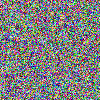

In [ ]:
%%testcell
# %%testcell
rng = numpy.random.default_rng(1234)
arr = rng.uniform(size=( 100,100,3)) * 255
img = Image.fromarray(arr.astype('uint8')).convert('RGB')
assert 'img' in locals()
img

NOTE: `PIL.Image`has a dedicated `__repr__` dunder that jupyter will use to proeprly display it.

In [ ]:
# Out of the test cell `img` has been removed
assert 'img' not in locals()

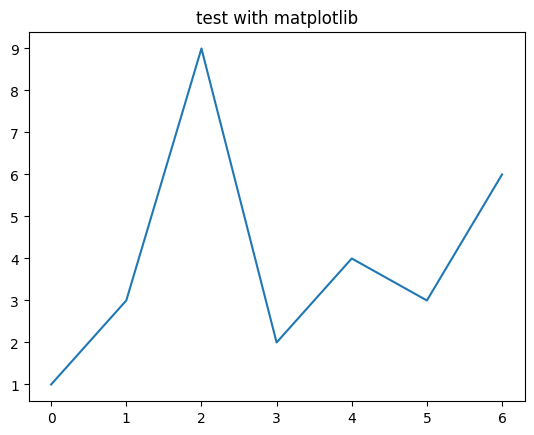

In [ ]:
%%testcell
# %%testcell
plt.plot([1,3,9,2,4,3,6])
plt.title('test with matplotlib');

Even Matplotlib figures are properly displayed. 

### `noreturn` option
This is a pretty advanced use case: `noreturn` option ensures that *no trace is left after cell execution*; despite you see some output after the cell execution, this is only "displayed" but the last result placeholder `_` is not updated.
This is useful when you're playing around with big abjects and you don't want them to pollute neither that *hidden* notebook state.

**NOTE:** `noreturn` option is automatically enabled using `testcelln`.

In [ ]:
%%testcell verbose
# %%testcell
'using %%testcell updates the last executed expression result "_"'

'using %%testcell updates the last executed expression result "_"'

In [ ]:
assert globals()['_']=='using %%testcell updates the last executed expression result "_"'

As we can see, `%%testcell` magic properly update the `_` state like in normal cell execution

In [ ]:
%%testcell noreturn verbose
# %%testcelln
'%%testcelln does not change "_"'

'%%testcelln does not change "_"'

In [ ]:
assert globals()['_']=='using %%testcell updates the last executed expression result "_"'

`%%testcelln` instead includes the `noreturn` option that avoids modifying last command execution `_`.

## inout syntax

This is the most advanced option and is meant to enable the 

XXXXXXXXXXX **cell as function idea** XXXXXXXX

In [ ]:
# Define some stuff in the global space
def my_global_func(x): return x*2
my_global_variable = 123

### Selectively add objects from global state

This is useful when we're developing something in isolation, but we need access to libraries, constants or other objects from the main scope.

In [ ]:
%%testcelln (my_global_func,my_global_variable)
print(globals().keys())

# We can now access only to these two additional functions
assert my_global_variable==123
assert my_global_func(1)==2

dict_keys(['my_global_func', 'my_global_variable', '__builtins__'])


### Selectively pushing changes to global state 

In [ ]:
assert 'kkk' not in globals().keys()
assert 'fff' not in globals().keys()

In [ ]:
%%testcelln (my_global_variable)->(kkk,fff) debug

kkk = 'this is a global variable created inside testcelln cell'
def fff(): 
    # this is a global function created inside testcelln cell
    return my_global_variable # we use a global variable that should not be accessible

In [ ]:
assert kkk=='this is a global variable created inside testcelln cell'
assert fff()==123

In [ ]:
# cleanup
del kkk
del fff

### Output objects from testcell

In [ ]:
%%testcell ->(kkk) debug

kkk = 'this is a global variable created inside testcelln cell'
def fff(): 
    # this is a global function created inside testcelln cell
    return my_global_variable # we use a global variable that should not be accessible

In [ ]:
assert kkk=='this is a global variable created inside testcelln cell'
assert 'fff' not in globals().keys()

In [ ]:
# cleanup
del kkk

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()